# EDA and post-processing

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
assert sys.version_info >= (3, 5)

from pathlib import Path
from pprint import pprint
import glob
import shutil
import json
import csv
import itertools
import pandas as pd
import numpy as np
from scipy import stats
from functools import partial, reduce
from time import time
from typing import List, Optional, Union

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import (confusion_matrix, balanced_accuracy_score, f1_score, matthews_corrcoef,
                             roc_auc_score, recall_score, precision_score, precision_recall_curve)

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, auc, roc_curve

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

fdir = Path.cwd()
print(fdir)
sys.path.append(str(fdir/'..'))
import src
from src.config import cfg
from src.post_processing import scores_boxplot, scores_barplot

/vol/ml/apartin/projects/pdx-histo/nbs


In [2]:
# For Alex Pearson
# df = pd.read_csv(fdir/"../data/processed/tidy_drug_pairs_all_samples/annotations_slideflow.csv")
# cols = [c for c in df.columns if c.startswith("dd1_") | c.startswith("dd2_") | c.startswith("ge_")]
# aa = df.drop(columns=cols)
# aa = aa.drop(columns=["index", "submitter_id", "slide", "trt", "aug", "smp", "grp_name"])
# aa.to_csv("pdx_drug_response_meta.csv", index=False)

# Tile counter per slide

In [3]:
tfr_dir = cfg.DATADIR/"PDX_FIXED_RSP_DRUG_PAIR"/"299px_302um"
tile_cnts = pd.read_csv(tfr_dir/"tile_counts_per_slide.csv")
print(tile_cnts.shape)

aa = tile_cnts.groupby("Response").agg({"max_tiles": "sum", "smp": "nunique", "Group": "nunique"}).reset_index().rename(
    columns={"max_tiles": "Tiles", "smp": "Samples", "Group": "Groups"})
display(aa)

print(aa.iloc[1,:]/aa.sum(axis=0))

(6962, 8)


,Response,Tiles,Samples,Groups
0,0,2517905,6631,917
1,1,141374,331,42


Response    1.000000
Tiles       0.053163
Samples     0.047544
Groups      0.043796
dtype: float64


# Ctype barplots 

This is from `src/eda.py`

(0, 290)

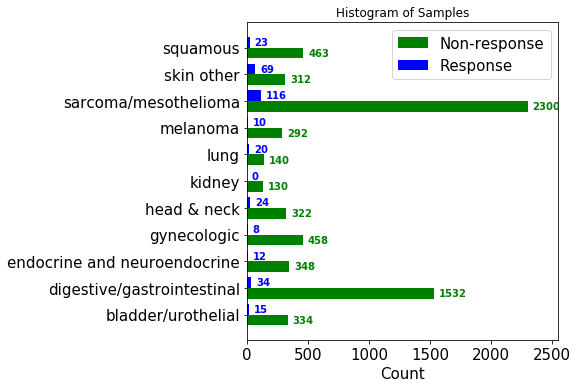

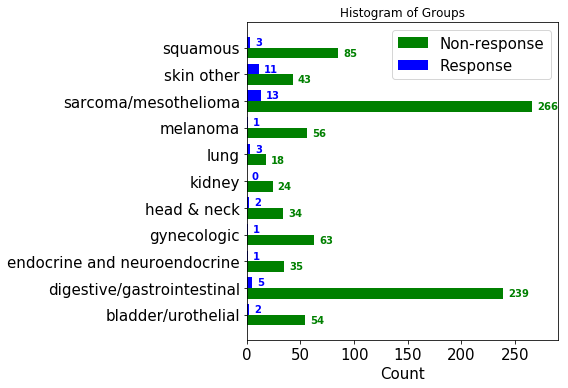

In [4]:
from src.eda import resp_dist_dict, barplot_sample_count

dataname = "tidy_drug_pairs_all_samples"
annotations_file = cfg.DATA_PROCESSED_DIR/dataname/cfg.SF_ANNOTATIONS_FILENAME
dtype = {"image_id": str, "slide": str}
data = pd.read_csv(annotations_file, dtype=dtype, engine="c", na_values=["na", "NaN"], low_memory=False)

# sns.histplot(data=data, y="ctype", hue="Response", multiple="dodge", shrink=.8)

agg_by = "Samples"
aa, resp_dict = resp_dist_dict(data, agg_by=agg_by, var="ctype", target="Response")
ax = barplot_sample_count(resp_dict, title=f"Histogram of {agg_by}", figsize=(8, 5.5));
plt.tight_layout()
ax.set_xlim([0, 2550])

agg_by = "Groups"
aa, resp_dict = resp_dist_dict(data, agg_by=agg_by, var="ctype", target="Response")
ax = barplot_sample_count(resp_dict, title=f"Histogram of {agg_by}", figsize=(8, 5.5));
plt.tight_layout()
ax.set_xlim([0, 290])

# Data summary

- PDX families(?)
- single-drug treatments and drug-pair treatments(v)
- gene expression profiles(v)
- histology images and tiles(v)
- of positive and negative instances at group level(v)
- of positive and negative instances at sample level(v)

In [5]:
sm = {}

In [6]:
print("Unique Samples", data.Sample.nunique())

Unique Samples 487


In [7]:
# cols = ["Group", "model", "trt", "smp", "ctype"]
# data.sort_values(cols)[cols][:30]

In [8]:
# PDX family
print(data.Group.nunique())
sm["PDX families"] = data.Group.nunique()

959


In [9]:
# Single drug treatments
df = data[data["Drug1"] == data["Drug2"]]
print(df.trt.nunique())
sm["Single-drug treatments"] = df.trt.nunique()

12


In [10]:
# Drug-pair treatments
df = data[data["Drug1"] != data["Drug2"]]
print(df.trt.nunique())
sm["Drug-pair treatments"] = df.trt.nunique()

72


In [11]:
# All treatments
print(data.trt.nunique())
sm["All treatments"] = data.trt.nunique()

84


In [12]:
# Gene expression profiles
ge = data[[c for c in data.columns if c.startswith("ge_")]]
ge = ge.drop_duplicates()
print(ge.shape[0] - ge.duplicated().sum())
print(ge.shape)
sm["Gene expression profiles"] = ge.shape[0]

487
(487, 942)


In [13]:
# Histology images
print(data.image_id.nunique())
sm["Histology slides"] = data.image_id.nunique()

487


In [14]:
# Histology tiles
df = data.drop_duplicates(subset=["image_id"])
print(df.shape)

df = df[["smp", "image_id", "slide", "Response"]].astype({"image_id": int, "slide": int})
df = df.merge(tile_cnts, on=["smp", "slide", "Response"], how="inner")
print(df.shape)
print(df["max_tiles"].sum())

sm["Histology tiles"] = df["max_tiles"].sum()

(487, 4954)
(487, 9)
177468


In [15]:
# Drug response samples in the ML dataset
sm["Drug response samples"] = data.shape[0]

In [16]:
# Single-drug response samples in the ML dataset
sm["Single-drug response samples"] = data[data.aug==False].shape[0]

In [17]:
# Single-drug response samples in the ML dataset
sm["Drug-pair response samples"] = data[data.aug==True].shape[0]

In [18]:
pd.Series(sm)

PDX families                       959
Single-drug treatments              12
Drug-pair treatments                72
All treatments                      84
Gene expression profiles           487
Histology slides                   487
Histology tiles                 177468
Drug response samples             6962
Single-drug response samples      2556
Drug-pair response samples        4406
dtype: int64

In [19]:
df[:2]

,smp,image_id,slide,Response,tfr_fname,max_tiles,n_tiles,Group,grp_name
0,114434~197-R~A35YC3_NSC.125973_NSC.125973,27166,27166,0,114434~197-R~A35YC3_NSC.125973_NSC.125973.tfre...,617,617,0,114434~197-R_NSC.125973_NSC.125973
1,114434~197-R~A36YC9_NSC.125973_NSC.125973,25127,25127,0,114434~197-R~A36YC9_NSC.125973_NSC.125973.tfre...,505,505,0,114434~197-R_NSC.125973_NSC.125973


In [20]:
aa = tile_cnts.groupby("Response").agg({"max_tiles": "sum", "smp": "nunique", "Group": "nunique"}).reset_index().rename(
    columns={"max_tiles": "Tiles", "smp": "Samples", "Group": "Groups"})
display(aa)

,Response,Tiles,Samples,Groups
0,0,2517905,6631,917
1,1,141374,331,42


In [21]:
tile_cnts[:3]

,tfr_fname,smp,slide,max_tiles,n_tiles,Group,grp_name,Response
0,512744~197-R~T59TM8_NSC.362856_NSC.752840.tfre...,512744~197-R~T59TM8_NSC.362856_NSC.752840,10065,94,94,425,512744~197-R_NSC.362856_NSC.752840,0
1,512744~197-R~T59TM8_NSC.362856_NSC.362856.tfre...,512744~197-R~T59TM8_NSC.362856_NSC.362856,10065,94,94,422,512744~197-R_NSC.362856_NSC.362856,0
2,512744~197-R~T59TM8_NSC.752840_NSC.362856.tfre...,512744~197-R~T59TM8_NSC.752840_NSC.362856,10065,94,94,425,512744~197-R_NSC.752840_NSC.362856,0


In [22]:
# # Number of drugs in single-drug treatments
# df = data.copy()
# df = df[df["Drug1"] == df["Drug2"]]
# print(df.Drug1.nunique())
# print(df.trt.nunique())

# dd1 = df[[c for c in df.columns if c.startswith("dd1_")]]
# dd2 = df[[c for c in df.columns if c.startswith("dd2_")]]
# print(dd1.shape[0] - dd1.duplicated().sum())
# print(dd2.shape[0] - dd2.duplicated().sum())

In [23]:
# # Number of drugs in drug-pair treatments
# df = data.copy()
# df = df[df["Drug1"] != df["Drug2"]]
# print(df.Drug1.nunique())
# print(df.trt.nunique())

# dd1 = df[[c for c in df.columns if c.startswith("dd1_")]]
# dd2 = df[[c for c in df.columns if c.startswith("dd2_")]]
# print(dd1.shape[0] - dd1.duplicated().sum())
# print(dd2.shape[0] - dd2.duplicated().sum())

In [24]:
# dd1 = data[[c for c in data.columns if c.startswith("dd1_")]]
# dd2 = data[[c for c in data.columns if c.startswith("dd2_")]]
# ge = data[[c for c in data.columns if c.startswith("ge_")]]

# print(dd1.shape[0] - dd1.duplicated().sum())
# print(dd2.shape[0] - dd2.duplicated().sum())
# print(ge.shape[0] - ge.duplicated().sum())

# Calibration

In [25]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(name, fig_index, y_true, probs, verbose=True, figsize=(8, 8)):
    """ Plot calibration curve for est w/o and with calibration.
    https://towardsdatascience.com/classifier-calibration-7d0be1e05452
    """
    # fig = plt.figure(fig_index, figsize=figsize)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax1 = plt.subplot2grid(shape=(3, 1), loc=(0, 0), rowspan=2)
    ax2 = plt.subplot2grid(shape=(3, 1), loc=(2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    frac_of_pos, mean_pred_value = calibration_curve(y_true, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f"{name}")
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="best")
    ax1.set_title(f"Calibration plot ({name})")

    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

    if verbose:
        print("Fraction of positives: {}".format(np.around(frac_of_pos, 3)))
        print("Mean prediction value: {}".format(np.around(mean_pred_value, 3)))
    return frac_of_pos, mean_pred_value

In [26]:
# split = 81
# split = 99
split = 76  # best scores
# split = 29
# split = 78

Fraction of positives: [0.002 0.087 0.254 0.413 0.48  0.494 0.454 0.58  0.71  0.994]
Mean prediction value: [0.016 0.144 0.244 0.345 0.447 0.548 0.65  0.753 0.846 0.971]


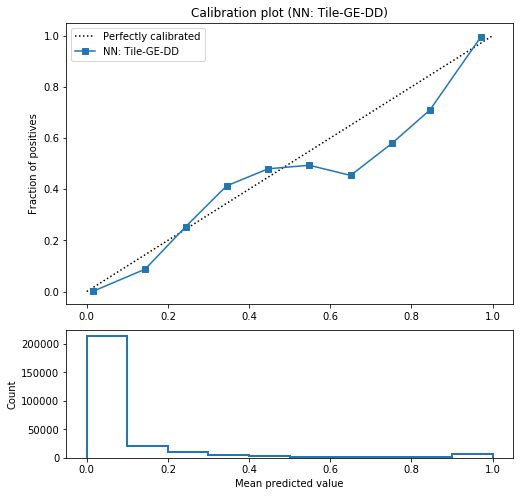

In [27]:
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd"

preds = pd.read_csv(sorted(datadir.glob(f"split_{split}*"))[0]/"test_tile_preds.csv")
fop, mpv = plot_calibration_curve("NN: Tile-GE-DD", 1, y_true=preds["y_true"], probs=preds["prob"])

Fraction of positives: [0.    0.    0.05  0.154 0.222 0.364 1.    1.    1.    1.   ]
Mean prediction value: [0.021 0.14  0.25  0.356 0.448 0.551 0.638 0.795 0.853 0.986]


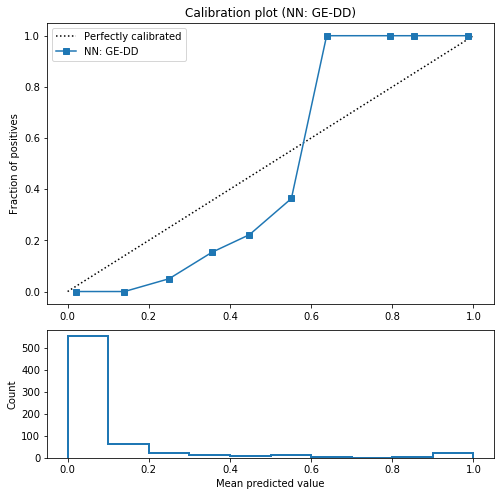

In [28]:
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_ge_dd"

preds = pd.read_csv(sorted(datadir.glob(f"split_{split}*"))[0]/"test_keras_smp_preds.csv")
fop, mpv = plot_calibration_curve("NN: GE-DD", 1, y_true=preds["y_true"], probs=preds["prob"])

Fraction of positives: [0.013 0.3   0.308 0.    0.    0.    0.    0.25  1.    0.667]
Mean prediction value: [0.018 0.142 0.24  0.317 0.457 0.539 0.63  0.767 0.853 0.944]


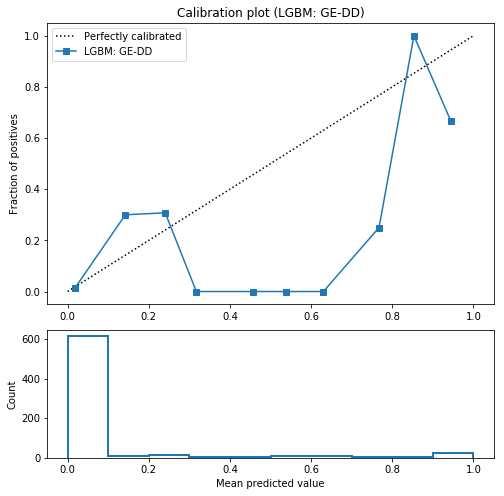

In [29]:
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
datadir = fdir/"../data/PDX_Transfer_Learning_Classification/Results_MultiModal_Learning/1.0_True_False_100_31"

preds = pd.read_csv(sorted(datadir.glob(f"cv_{split}*"))[0]/"test_preds.csv")
fop, mpv = plot_calibration_curve("LGBM: GE-DD", 1, y_true=preds["Response"], probs=preds["prediction"])

# Agg Scores

This is `src/post_processing.py`

Test scores were not found for these splits: []
Test scores were not found for these splits: []
Test scores were not found for these splits: []
Test scores were not found for these splits: []


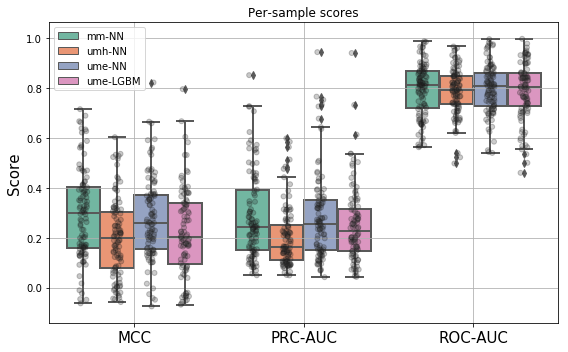

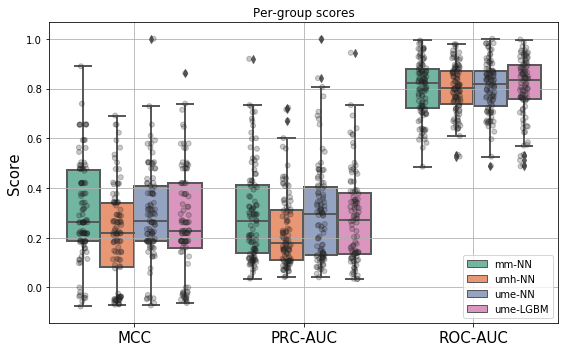

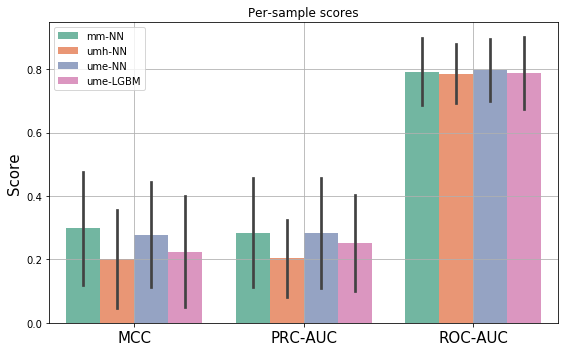

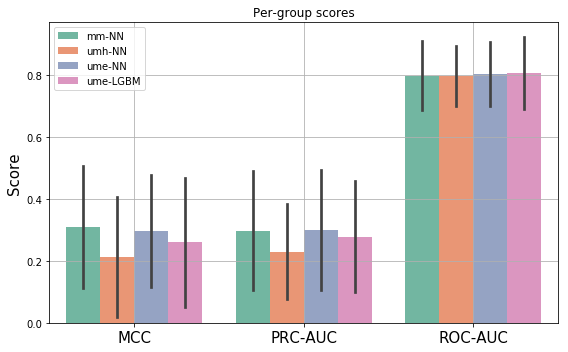

In [34]:
from src.post_processing import agg_scores_from_splits, scores_boxplot, scores_barplot, t_test, t_test_all_metrics

# Multimodal
mm = agg_scores_from_splits(
    datadir=fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd",
    fname="test_scores.csv", prfx="split_")
mm = mm.rename(columns={"pred_for": "metric"})
mm["model"] = "mm-NN"

umh = agg_scores_from_splits(
    datadir=fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_dd",
    fname="test_scores.csv", prfx="split_")
umh = umh.rename(columns={"pred_for": "metric"})
umh["model"] = "umh-NN"

# Unimodal - gene expression
ume = agg_scores_from_splits(
    datadir=fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_ge_dd",
    fname="test_keras_scores.csv", prfx="split_")
ume["model"] = "ume-NN"

# LGBM
lgbm = agg_scores_from_splits(
    datadir=fdir/"../data/PDX_Transfer_Learning_Classification/Results_MultiModal_Learning/1.0_True_False_100_31",
    fname="te_scores.csv", prfx="cv_")
lgbm["model"] = "ume-LGBM"

# ------------------------------------
# Agg scores from all models
# ------------------------------------
# Concat scores from all models
df_list_org = [mm, umh, ume, lgbm] #, ume_drop_aug, ume_only_pairs]
# ll = [set(df.columns) for df in df_list_org]
# common_cols = list(reduce(set.intersection, ll))
common_cols = ["metric", "smp", "Group", "split", "model"]
df_list = [df[common_cols] for df in df_list_org]
all_scores = pd.concat(df_list, axis=0).reset_index(drop=True)

# Keep common metrics
ll = [set(df["metric"].values) for df in df_list]
common_metrics = list(reduce(set.intersection, ll))
all_scores = all_scores[all_scores["metric"].isin(common_metrics)].reset_index(drop=True)

# Rename metric names
def rename_items_of_single_col(x, mapper_dict):
    """ mapper_dict where keys and values are the old and new values, respectively. """
    for k, v in mapper_dict.items():
        if k == x:
            return mapper_dict[k]
    return x

mapper = {"brier": "Brier", "mcc": "MCC", "pr_auc": "PRC-AUC", "roc_auc": "ROC-AUC"}
all_scores["metric"] = all_scores["metric"].map(lambda x: rename_items_of_single_col(x, mapper))

# Drop metrics
met_drop = ["Brier"]
all_scores = all_scores[~all_scores["metric"].isin(met_drop)]
all_scores = all_scores.sort_values(["metric", "split"], ascending=True)

# Boxplot
ax = scores_boxplot(df=all_scores, x_name="metric", y_name="smp", hue_name="model", title="Per-sample scores")
ax = scores_boxplot(df=all_scores, x_name="metric", y_name="Group", hue_name="model", title="Per-group scores")

# Barplot
ax = scores_barplot(df=all_scores, x_name="metric", y_name="smp", hue_name="model", title=f"Per-sample scores")
ax = scores_barplot(df=all_scores, x_name="metric", y_name="Group", hue_name="model", title=f"Per-group scores")

In [35]:
all_scores

,metric,smp,Group,split,model
1,MCC,0.233118,0.186541,0,mm-NN
401,MCC,0.058446,0.112975,0,umh-NN
803,MCC,0.135895,0.143032,0,ume-NN
1203,MCC,0.203213,0.218085,0,ume-LGBM
4,MCC,0.587811,0.544721,1,mm-NN
...,...,...,...,...,...
1595,ROC-AUC,0.794429,0.750000,98,ume-LGBM
398,ROC-AUC,0.673137,0.640476,99,mm-NN
799,ROC-AUC,0.691388,0.664286,99,umh-NN
1198,ROC-AUC,0.689808,0.666667,99,ume-NN


# ROC-AUC and PRC-AUC

In [36]:
def calc_ap(y_true, y_pred):
    """ Average precision. """
    print("micro: {:.10f}".format(metrics.average_precision_score(y_true, y_pred, average='micro')))
    print("macro: {:.10f} ".format(metrics.average_precision_score(y_true, y_pred, average='macro')))
    print("weighted: {:.10f} ".format(metrics.average_precision_score(y_true, y_pred, average='weighted')))
    print("samples: {:.10f} ".format(metrics.average_precision_score(y_true, y_pred, average='samples')))

In [57]:
met = "ROC-AUC"
# met = "PRC-AUC"

model = "mm-NN"
agg_by = "smp"
jj = all_scores[(all_scores["metric"]==met) & (all_scores["model"]==model)].sort_values(agg_by, ascending=False)
display(jj[:3])

split = jj.iloc[0]["split"]
print(split)

,metric,smp,Group,split,model
306,ROC-AUC,0.98712,0.993407,76,mm-NN
147,ROC-AUC,0.98481,0.980435,36,mm-NN
376,ROC-AUC,0.97761,0.983696,94,mm-NN


76


In [107]:
mm  = all_scores[(all_scores["metric"]==met) & (all_scores["model"]=="mm-NN")].rename(columns={agg_by: "mm_NN"}).drop(columns=["metric", "model", "Group"])
ume = all_scores[(all_scores["metric"]==met) & (all_scores["model"]=="ume-NN")].rename(columns={agg_by: "ume_NN"}).drop(columns=["metric", "model", "Group"])
umh = all_scores[(all_scores["metric"]==met) & (all_scores["model"]=="umh-NN")].rename(columns={agg_by: "umh_NN"}).drop(columns=["metric", "model", "Group"])
lgb = all_scores[(all_scores["metric"]==met) & (all_scores["model"]=="ume-LGBM")].rename(columns={agg_by: "ume_LGBM"}).drop(columns=["metric", "model", "Group"])
jj = mm.merge(ume, on="split", how="inner")
jj = jj.merge(umh, on="split", how="inner")
jj = jj.merge(lgb, on="split", how="inner")
jj["mm-ume"] = jj["mm_NN"] - jj["ume_NN"]
jj["mm-umh"] = jj["mm_NN"] - jj["umh_NN"]
jj["mm-lgb"] = jj["mm_NN"] - jj["ume_LGBM"]
jj = jj.sort_values(["mm-ume", "mm-umh", "mm-lgb"], ascending=False)
jj[-10:]

,mm_NN,split,ume_NN,umh_NN,ume_LGBM,mm-ume,mm-umh,mm-lgb
18,0.787030,18,0.860926,0.799507,0.777820,-0.073896,-0.012477,0.009211
64,0.810703,64,0.885939,0.853967,0.861076,-0.075236,-0.043264,-0.050373
7,0.667992,7,0.744807,0.667678,0.766417,-0.076814,0.000314,-0.098425
35,0.589195,35,0.671450,0.497724,0.460145,-0.082255,0.091471,0.129050
50,0.688112,50,0.778920,0.752753,0.842056,-0.090809,-0.064641,-0.153944
23,0.653418,23,0.758051,0.726729,0.729538,-0.104634,-0.073312,-0.076120
91,0.692180,91,0.817669,0.829524,0.813985,-0.125489,-0.137343,-0.121805
16,0.643299,16,0.775363,0.838680,0.805375,-0.132064,-0.195381,-0.162076
90,0.570827,90,0.716434,0.795799,0.679898,-0.145607,-0.224972,-0.109071
59,0.562926,59,0.715720,0.707884,0.688210,-0.152794,-0.144957,-0.125284


In [58]:
# # Find split where mm is better with the largest margin
# mm = all_scores[(all_scores["metric"]==met) & (all_scores["model"]=="mm-NN")].rename(columns={agg_by: "mm"}).drop(columns=["metric", "model", "Group"])
# ume = all_scores[(all_scores["metric"]==met) & (all_scores["model"]=="ume-NN")].rename(columns={agg_by: "ume"}).drop(columns=["metric", "model", "Group"])
# jj = mm.merge(ume, on="split", how="inner")
# jj["better"] = jj["mm"] > jj["ume"]
# jj["mm-ume"] = jj["mm"] - jj["ume"]
# # jj = jj.sort_values(["better", "mm"], ascending=False)
# jj = jj.sort_values(["mm-ume", "mm"], ascending=False)
# jj[:3]

,mm,split,ume,better,mm-ume
44,0.817678,44,0.697231,True,0.120447
70,0.726698,70,0.634143,True,0.092555
0,0.894562,0,0.808675,True,0.085888


In [59]:
print("Number of splits for which mm-NN is better that ume-NN: {}".format(jj["better"].sum()))
print("Splits for which mm-NN is better that ume-NN: \n{}".format(sorted(jj[jj["better"]].split.values)))
ff = jj[jj["better"]].sort_values("mm-ume", ascending=False).reset_index(drop=True)

_, p_value = stats.ttest_rel(ff["mm"].values, ff["ume"].values, axis=0, alternative="two-sided")
print("P-value: {}".format(p_value))

ff[:10]

Number of splits for which mm-NN is better that ume-NN: 46
Splits for which mm-NN is better that ume-NN: 
[0, 1, 10, 11, 12, 13, 15, 19, 20, 22, 24, 28, 30, 32, 33, 34, 36, 38, 39, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 56, 57, 60, 61, 65, 66, 67, 68, 70, 75, 78, 79, 84, 88, 89, 94, 95]
P-value: 2.050152177518117e-13


,mm,split,ume,better,mm-ume
0,0.817678,44,0.697231,True,0.120447
1,0.726698,70,0.634143,True,0.092555
2,0.894562,0,0.808675,True,0.085888
3,0.820284,24,0.734735,True,0.085549
4,0.664854,12,0.585070,True,0.079783
5,0.860877,46,0.781319,True,0.079558
6,0.827405,30,0.748746,True,0.078659
7,0.839330,67,0.768191,True,0.071139
8,0.846976,53,0.777514,True,0.069462
9,0.786837,39,0.718018,True,0.068819


In [108]:
# split = 44  # mm better
# split = 59  # ume better
split = 18  # ume better
print(split)

18


In [112]:
datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd"
splitdir = sorted(datadir.glob(f"split_{split}_*"))[0]
if agg_by == "smp":
    fpath = splitdir/"test_smp_preds.csv"
else:
    fpath = splitdir/"test_grp_preds.csv"
mm = pd.read_csv(splitdir/fpath)


datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_dd"
splitdir = sorted(datadir.glob(f"split_{split}_*"))[0]
if agg_by == "smp":
    fpath = splitdir/"test_smp_preds.csv"
else:
    fpath = splitdir/"test_grp_preds.csv"
umh = pd.read_csv(splitdir/fpath)


datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_ge_dd"
splitdir = sorted(datadir.glob(f"split_{split}_*"))[0]
if agg_by == "smp":
    fpath = splitdir/"test_keras_smp_preds.csv"
else:
    fpath = splitdir/"test_keras_grp_preds.csv"
ume = pd.read_csv(splitdir/fpath)


datadir = fdir/"../data/PDX_Transfer_Learning_Classification/Results_MultiModal_Learning/1.0_True_False_100_31"
splitdir = sorted(datadir.glob(f"cv_{split}"))[0]
if agg_by == "smp":
    fpath = splitdir/"test_preds.csv"
else:
    fpath = splitdir/"test_preds.csv"
lgb = pd.read_csv(splitdir/fpath)

In [113]:
print("\nMM")
calc_ap(y_true=mm.Response, y_pred=mm.prob)
print("\nUME")
calc_ap(y_true=ume.Response, y_pred=ume.prob)
print("\nLGBM")
calc_ap(y_true=lgb.Response, y_pred=lgb.prediction)


MM
micro: 0.1608930695
macro: 0.1608930695 
weighted: 0.1608930695 
samples: 0.1608930695 

UME
micro: 0.1622600332
macro: 0.1622600332 
weighted: 0.1622600332 
samples: 0.1622600332 

LGBM
micro: 0.2094419510
macro: 0.2094419510 
weighted: 0.2094419510 
samples: 0.2094419510 


In [115]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

mm_roc = roc_auc_score(y_true=mm["Response"], y_score=mm["prob"])
mm_fpr, mm_tpr, _ = roc_curve(y_true=mm["Response"], y_score=mm["prob"])
print(mm_roc)

umh_roc = roc_auc_score(y_true=umh["Response"], y_score=umh["prob"])
umh_fpr, umh_tpr, _ = roc_curve(y_true=umh["Response"], y_score=umh["prob"])
print(umh_roc)

ume_roc = roc_auc_score(y_true=ume["Response"], y_score=ume["prob"])
ume_fpr, ume_tpr, _ = roc_curve(y_true=ume["Response"], y_score=ume["prob"])
print(ume_roc)

lgb_roc = roc_auc_score(y_true=lgb["Response"], y_score=lgb["prediction"])
lgb_fpr, lgb_tpr, _ = roc_curve(y_true=lgb["Response"], y_score=lgb["prediction"])
print(lgb_roc)

0.78703007518797
0.7995065789473683
0.8609257518796993
0.7778195488721804


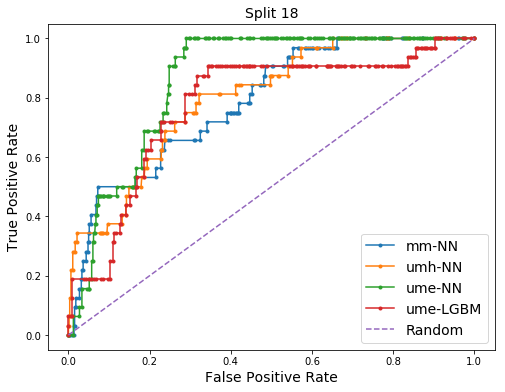

In [116]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(mm_fpr, mm_tpr, ".-", label="mm-NN")
ax.plot(umh_fpr, umh_tpr, ".-", label="umh-NN")
ax.plot(ume_fpr, ume_tpr, ".-", label="ume-NN")
ax.plot(lgb_fpr, lgb_tpr, ".-", label="ume-LGBM")
ax.plot([0, 1], [0, 1], "--", label="Random")
ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14)
ax.set_title(f"Split {split}", fontsize=14)
ax.legend(fontsize=14);
plt.savefig(fdir/f"../projects/bin_rsp_drug_pairs_all_samples/{met}-split_{split}.png", dpi=150)

In [17]:
# split = 76
# agg_by = "smp"
# ax = scores_barplot(df=all_scores[all_scores["split"].isin([split])], x_name="metric", y_name=agg_by, hue_name="model", title=f"Per-sample scores (split {split})")

# split = 99
# agg_by = "smp"
# ax = scores_barplot(df=all_scores[all_scores["split"].isin([split])], x_name="metric", y_name=agg_by, hue_name="model", title=f"Per-sample scores (split {split})")

In [19]:
# split = 99
# print(f"Split {split}")
# display(pd.pivot(all_scores[all_scores["split"]==split], index="metric", columns="model", values=["smp", "Group"]))

# split = 81
# print(f"Split {split}")
# display(pd.pivot(all_scores[all_scores["split"]==split], index="metric", columns="model", values=["smp", "Group"]))

In [20]:
# df = all_scores
# split = 99
# met = "PRC-AUC"
# df[(df["split"]==split) & (df["metric"]==met)]

In [21]:
# split = 81
# met = "PRC-AUC"
# df[(df["split"]==split) & (df["metric"]==met)]

### Consider top N splits

In [36]:
# met = "PRC-AUC"
# j = all_scores
# n = 30
# j1 = j[(j["metric"] == met) & (j["model"] == "NN: Tile-GE-DD")].sort_values("smp", ascending=False)
# j2 = j[(j["metric"] == met) & (j["model"] == "NN: GE-DD")].sort_values("smp", ascending=False)
# j3 = j[(j["metric"] == met) & (j["model"] == "LGBM: GE-DD")].sort_values("smp", ascending=False)

# s1 = j1[:n]["split"].values
# s2 = j2[:n]["split"].values
# s3 = j3[:n]["split"].values

# from functools import reduce
# splits = list(reduce(set.union, [set(item) for item in [s1, s2, s3]]))

In [29]:
# xx = all_scores[all_scores["split"].isin(splits)]
# ax = scores_boxplot(df=xx, x_name="metric", y_name="smp", hue_name="model", title=f"Per-sample scores ({len(splits)} splits)")

# Calc Scores

In [111]:
from src.ml.evals import calc_scores
from src.models import agg_tile_preds

In [59]:
split = 44

datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd"
splitdir = sorted(datadir.glob(f"split_{split}_*"))[0]

if agg_by == "smp":
    fpath = splitdir/"test_smp_preds.csv"
else:
    fpath = splitdir/"test_grp_preds.csv"
mm = pd.read_csv(splitdir/fpath)

In [63]:
y_true = mm.Response.values
y_pred = mm.prob.values

In [41]:
if agg_by == "smp":
    fpath = splitdir/"test_preds.csv"
else:
    fpath = splitdir/"test_preds.csv"
lgb = pd.read_csv(splitdir/fpath)

prd = pd.read_csv(fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd/split_44_tile_ge_dd1_dd2_2021-05-12_h19-m07/test_tile_preds.csv")
print(prd.shape)
display(prd[:3])

(245470, 5)


,smp,tile_id,prob,y_true,y_pred_label
0,933738~175-T~W55VZ2TH4_NSC.785004_NSC.761431,0,0.001065,0,0
1,119177~322-R1~PXWJH4_NSC.681239_NSC.606869,0,0.263700,0,0
2,833975~119-R~EN1L20X95_NSC.616348_NSC.616348,0,0.001755,0,0


In [54]:
# ap = average_precision_score(prd.y_true, prd.prob, average='macro', pos_label=1, sample_weight=None)

y_true = prd.y_true.values
y_pred = prd.prob.values

In [64]:
print("micro: {:.10f}".format(metrics.average_precision_score(y_true, y_pred, average='micro')))
print("macro: {:.10f} ".format(metrics.average_precision_score(y_true, y_pred, average='macro')))
print("weighted: {:.10f} ".format(metrics.average_precision_score(y_true, y_pred, average='weighted')))
print("samples: {:.10f} ".format(metrics.average_precision_score(y_true, y_pred, average='samples')))  

micro: 0.1408545540
macro: 0.1408545540 
weighted: 0.1408545540 
samples: 0.1408545540 


In [65]:
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
metrics.auc(recall, precision)

0.13509222968530965

In [ ]:
mm = agg_scores_from_splits(
    datadir=fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd",
    fname="test_scores.csv", prfx="split_", print_fn=print_fn)

In [ ]:
ume = agg_scores_from_splits(
    datadir=fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_ge_dd",
    fname="test_keras_scores.csv", prfx="split_", print_fn=print_fn)

In [157]:
datadir=fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd"
prfx="split_"
fname="test_smp_preds.csv"

In [151]:
datadir=fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_ge_dd"
prfx="split_"
fname="test_keras_smp_preds.csv"

In [158]:
splits_dir_list = sorted(datadir.glob(f"{prfx}*"))
split_dir = splits_dir_list[99]
print(split_dir)
# split_id = str(split_dir.name).split(prfx)[1].split("_")[0]
fpath = split_dir/fname

if fpath.exists():
    prd = pd.read_csv(fpath)
    meta = pd.read_csv(split_dir/"te_meta.csv")
    #scores = calc_scores(prd.y_true, prd.prob, mltype="cls")

/vol/ml/apartin/projects/pdx-histo/nbs/../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd/split_9_tile_ge_dd1_dd2_2021-05-11_h17-m51


In [159]:
# smp_preds = agg_tile_preds(prd, agg_by="smp", meta=meta, agg_method="mean")

In [161]:
scores = calc_scores(prd.Response, prd.prob, mltype="cls")

# Error analysis

### Tile-GE-DD

In [163]:
from src.models import calc_tf_preds, agg_tile_preds

def add_conf_data(data, label_col_name, prob_col_name, p=0.5):
    """ Add columns are used to calc confusion matrix TP, TN, FN, FP. """
    if "TP" not in data.columns:
        data["TP"] = data.apply(lambda row: row[prob_col_name]>=p if row[label_col_name]==1 else False, axis=1)  # tp
    if "TN" not in data.columns:
        data["TN"] = data.apply(lambda row: row[prob_col_name] <p if row[label_col_name]==0 else False, axis=1)  # tn
    if "FN" not in data.columns:
        data["FN"] = data.apply(lambda row: row[prob_col_name] <p if row[label_col_name]==1 else False, axis=1)  # fn
    if "FP" not in data.columns:
        data["FP"] = data.apply(lambda row: row[prob_col_name]>=p if row[label_col_name]==0 else False, axis=1)  # fp

#     data['TPR'] = data.apply(lambda row: np.nan if (row.TP==0) & (row.FN==0) else row.TP / (row.TP + row.FN), axis=1)  # sensitivity, recall: TP/P = TP/(TP+FN)
#     data['TNR'] = data.apply(lambda row: np.nan if (row.TN==0) & (row.FP==0) else row.TN / (row.TN + row.FP), axis=1)  # specificity: TN/N = TN/(TN+FP)
    
#     data['FPR'] = data.apply(lambda row: np.nan if (row.TN==0) & (row.FP==0) else row.FP / (row.TN + row.FP), axis=1)  # fall-out: FP/N = FP/(FP+TN)
#     data['FNR'] = data.apply(lambda row: np.nan if (row.TP==0) & (row.FN==0) else row.FN / (row.TP + row.FN), axis=1)  # miss-rate: FN/NP = FN/(FN+TP)
    return data

In [182]:
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_tile_ge_dd"

rundir = sorted(datadir.glob("split_59*"))[0]
mm_tile_preds = pd.read_csv(rundir/"test_tile_preds.csv").sort_values("smp")
meta = pd.read_csv(rundir/"te_meta.csv")

cols = ["smp", "Sample", "trt", "Group", "ctype", "image_id"]

# print(f"Unique Samples:    {df['Sample'].nunique()}")
# print(f"Unique treatments: {df['trt'].nunique()}")
# print(f"Unique groups:     {df['Group'].nunique()}")
# print(f"Unique ctypes:     {df['ctype'].nunique()}")

In [183]:
# mm_tile_preds = mm_tile_preds.sort_values("smp")
mm_tile_preds

,smp,tile_id,prob,y_true,y_pred_label
238614,114551~080-T~M667M226C29_NSC.606869_NSC.681239,15,0.016780,0,0
240474,114551~080-T~M667M226C29_NSC.606869_NSC.681239,84,0.008280,0,0
249335,114551~080-T~M667M226C29_NSC.606869_NSC.681239,413,0.018480,0,0
251574,114551~080-T~M667M226C29_NSC.606869_NSC.681239,496,0.033660,0,0
245915,114551~080-T~M667M226C29_NSC.606869_NSC.681239,286,0.021740,0,0
...,...,...,...,...,...
117948,BL0479~F1894~M24M216_NSC.758246_NSC.758246,96,0.000933,0,0
117975,BL0479~F1894~M24M216_NSC.758246_NSC.758246,97,0.000661,0,0
118002,BL0479~F1894~M24M216_NSC.758246_NSC.758246,98,0.000519,0,0
117759,BL0479~F1894~M24M216_NSC.758246_NSC.758246,89,0.000989,0,0


In [184]:
# # ---------------
# # Check passage
# # ---------------
# vv = meta["sample_id"].values

# out = []
# cnt = []
# p_id_problem = []
# for i, value in enumerate(vv):
#     if value.upper() == "ORIGINATOR":
#         out.append("ORIGINATOR")
#     elif "AL" in value.upper():
#         # print("Alternative site.")
#         cnt.append(value.upper())
#     elif "RG" in value.upper():
#         # print("Regrowth from a viably cryo-preserved fragment.")
#         out.append("RG")
#         cnt.append(value.upper())
#     elif "POOL" in value.upper():
#         # print("Pooled.")
#         cnt.append(value.upper())
#     elif ("PDC" or "CAF") in value.upper():
#         # print("PDC or CAF.")
#         cnt.append(value.upper())
#     else:
#         if len(value) % 3 != 0:
#             # print("Problem with passage ID")
#             p_id_problem.append(value)
#         else:
#             out.append("P" + str(int(len(value)/3)))
            
# print(cnt)
# print(p_id_problem)

In [185]:
mm_smp_preds = agg_tile_preds(mm_tile_preds, agg_by="smp", meta=meta, agg_method="mean")
mm_smp_preds = mm_smp_preds[cols + ["prob", "Response"]]
mm_smp_preds = add_conf_data(mm_smp_preds, label_col_name="Response", prob_col_name="prob", p=0.5)
mm_smp_preds.sort_values("smp")#[:4]

,smp,Sample,trt,Group,ctype,image_id,prob,Response,TP,TN,FN,FP
0,114551~080-T~M667M226C29_NSC.606869_NSC.681239,114551~080-T~M667M226C29,NSC.606869_NSC.681239,649,head & neck,16142,0.012808,0,False,True,False,False
1,114551~080-T~M667M226C29_NSC.681239_NSC.606869,114551~080-T~M667M226C29,NSC.681239_NSC.606869,649,head & neck,16142,0.008779,0,False,True,False,False
2,114551~080-T~M667M227C30_NSC.606869_NSC.681239,114551~080-T~M667M227C30,NSC.606869_NSC.681239,649,head & neck,16131,0.012890,0,False,True,False,False
3,114551~080-T~M667M227C30_NSC.681239_NSC.606869,114551~080-T~M667M227C30,NSC.681239_NSC.606869,649,head & neck,16131,0.010772,0,False,True,False,False
4,114551~080-T~M667M228C43_NSC.606869_NSC.681239,114551~080-T~M667M228C43,NSC.606869_NSC.681239,649,head & neck,16149,0.010887,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
689,BL0479~F1894~M23M207M324M413_NSC.758246_NSC.75...,BL0479~F1894~M23M207M324M413,NSC.758246_NSC.758246,941,bladder/urothelial,44532,0.000782,0,False,True,False,False
682,BL0479~F1894~M23_NSC.362856_NSC.362856,BL0479~F1894~M23,NSC.362856_NSC.362856,935,bladder/urothelial,44504,0.010622,0,False,True,False,False
683,BL0479~F1894~M23_NSC.758246_NSC.758246,BL0479~F1894~M23,NSC.758246_NSC.758246,941,bladder/urothelial,44504,0.001163,0,False,True,False,False
690,BL0479~F1894~M24M216_NSC.362856_NSC.362856,BL0479~F1894~M24M216,NSC.362856_NSC.362856,935,bladder/urothelial,44510,0.014097,0,False,True,False,False


In [190]:
mm_smp_preds["pred_label"] = mm_smp_preds["prob"] > 0.5
mm_smp_preds["hit"] = mm_smp_preds["Response"] == mm_smp_preds["pred_label"] 

In [191]:
mm_smp_preds.groupby("ctype").agg({"hit": "sum", "smp": "nunique"}).reset_index()

,ctype,hit,smp
0,bladder/urothelial,21,21
1,digestive/gastrointestinal,153,153
2,endocrine and neuroendocrine,22,34
3,gynecologic,50,50
4,head & neck,34,34
5,kidney,15,15
6,lung,0,6
7,melanoma,34,34
8,sarcoma/mesothelioma,237,245
9,skin other,43,57


In [188]:
df["hit"].sum()

646

(692, 14)

In [23]:
# fop, mpv = plot_calibration_curve("NN: Tile-GE-DD", 1, y_true=mm_smp_preds["Response"], probs=mm_smp_preds["prob"])

In [24]:
# False positives
aa = mm_smp_preds[mm_smp_preds["FP"]].sort_values(["ctype", "prob"])
print(aa.shape)
# aa

(21, 12)


In [25]:
# split_on = "Group"
# meta.groupby(["ctype", "Response"]).agg({split_on: "nunique", "smp": "nunique"}).reset_index().rename(
#     columns={split_on: f"{split_on}_unq", "smp": "smp_unq"})

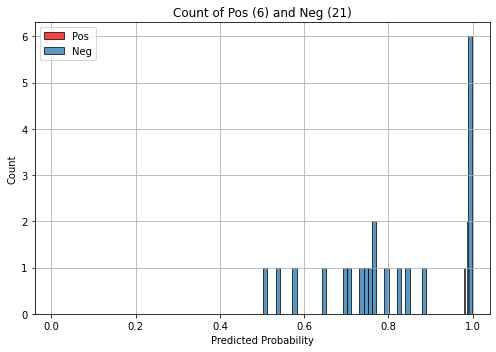

In [26]:
figsize=(7, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

df = mm_smp_preds
# pos_df = df[df["Response"]==1]
# neg_df = df[df["Response"]==0]
pos_df = df[(df["Response"]==1) & (df["prob"]>=0.5)]
neg_df = df[(df["Response"]==0) & (df["prob"]>=0.5)]

ax = sns.histplot(pos_df["prob"], bins=50, kde=False, ax=ax, color='r', label="Pos");
ax = sns.histplot(neg_df["prob"], bins=50, kde=False, ax=ax, label="Neg");
ax.set_title('Count of Pos ({}) and Neg ({})'.format( pos_df.shape[0], neg_df.shape[0] ))
ax.set_ylabel('Count');
ax.set_xlabel('Predicted Probability');
ax.set_xlim(left=-0.04, right=1.04)
ax.grid(True)
ax.legend();

plt.tight_layout()
# plt.savefig(out_postproc_fpath/'FNs_FPs_hist_all.png', dpi=150)

### GE-DD

In [27]:
dataname = "tidy_drug_pairs_all_samples"
prjname = "bin_rsp_drug_pairs_all_samples"
datadir = fdir/"../projects/bin_rsp_drug_pairs_all_samples/runs_ge_dd"

rundir = sorted(datadir.glob("split_99*"))[0]
sm_smp_preds = pd.read_csv(rundir/"test_keras_smp_preds.csv")
meta = pd.read_csv(rundir/"te_meta.csv")

In [28]:
sm_smp_preds = sm_smp_preds[cols + ["prob", "Response"]]
sm_smp_preds = add_conf_data(data=sm_smp_preds, label_col_name="Response", prob_col_name="prob", p=0.5)
sm_smp_preds[:4]

,smp,Sample,trt,Group,ctype,image_id,prob,Response,TP,TN,FN,FP
0,114551~080-T~M667M226C29_NSC.747599_NSC.125973,114551~080-T~M667M226C29,NSC.747599_NSC.125973,334,head & neck,16142,0.3267,0,False,True,False,False
1,114551~080-T~M667M226C29_NSC.125973_NSC.747599,114551~080-T~M667M226C29,NSC.125973_NSC.747599,334,head & neck,16142,0.2050,0,False,True,False,False
2,114551~080-T~M667M227C30_NSC.747599_NSC.125973,114551~080-T~M667M227C30,NSC.747599_NSC.125973,334,head & neck,16131,0.2411,0,False,True,False,False
3,114551~080-T~M667M227C30_NSC.125973_NSC.747599,114551~080-T~M667M227C30,NSC.125973_NSC.747599,334,head & neck,16131,0.2184,0,False,True,False,False


In [30]:
# False positives
bb = sm_smp_preds[sm_smp_preds["FP"]].sort_values(["ctype", "prob"])
print(bb.shape)
# bb

(21, 12)
